## Training Hyperspectral Dataset


In [1]:
pip install rasterio numpy matplotlib

   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
    --------------------------------------- 0.5/25.5 MB 8.2 MB/s eta 0:00:04
   --- ------------------------------------ 2.4/25.5 MB 8.9 MB/s eta 0:00:03
   ------------ --------------------------- 7.9/25.5 MB 16.2 MB/s eta 0:00:02
   --------------------- ------------------ 13.4/25.5 MB 20.0 MB/s eta 0:00:01
   ------------------------------ --------- 19.1/25.5 MB 21.6 MB/s eta 0:00:01
   ---------------------------------- ----- 22.0/25.5 MB 19.9 MB/s eta 0:00:01
   ---------------------------------------- 25.5/25.5 MB 19.9 MB/s  0:00:01

   ---------------------------------------- 0/5 [attrs]
   ---------------------------------------- 0/5 [attrs]
   -------- ------------------------------- 1/5 [affine]
   ---------------- ----------------------- 2/5 [cligj]
   -------------------------------- ------- 4/5 [rasterio]
   -------------------------------- ------- 4/5 [rasterio]
   -------------------------------- -----

In [3]:
import os
import rasterio
import numpy as np

# BASE PATH — CHANGE THIS TO YOUR OWN
base = r"D:\Agri 4.0\datasets\S2A_MSIL2A_20251114T045231_N0511_R076_T45RTJ_20251114T071709.SAFE"
granule = os.path.join(base, "GRANULE", "L2A_T45RTJ_A054299_20251114T045234", "IMG_DATA", "R10m")

# Important bands (10m resolution)
B02 = os.path.join(granule, "T45RTJ_20251114T045231_B02_10m.jp2")
B03 = os.path.join(granule, "T45RTJ_20251114T045231_B03_10m.jp2")
B04 = os.path.join(granule, "T45RTJ_20251114T045231_B04_10m.jp2")
B08 = os.path.join(granule, "T45RTJ_20251114T045231_B08_10m.jp2")

print(B02)


D:\Agri 4.0\datasets\S2A_MSIL2A_20251114T045231_N0511_R076_T45RTJ_20251114T071709.SAFE\GRANULE\L2A_T45RTJ_A054299_20251114T045234\IMG_DATA\R10m\T45RTJ_20251114T045231_B02_10m.jp2


In [4]:
print(os.listdir(granule))


['T45RTJ_20251114T045231_AOT_10m.jp2', 'T45RTJ_20251114T045231_B02_10m.jp2', 'T45RTJ_20251114T045231_B03_10m.jp2', 'T45RTJ_20251114T045231_B04_10m.jp2', 'T45RTJ_20251114T045231_B08_10m.jp2', 'T45RTJ_20251114T045231_TCI_10m.jp2', 'T45RTJ_20251114T045231_WVP_10m.jp2']


In [5]:
def load_band(path):
    with rasterio.open(path) as src:
        return src.read(1).astype("float32")

blue  = load_band(B02)
green = load_band(B03)
red   = load_band(B04)
nir   = load_band(B08)


In [6]:
print(blue.shape, red.shape, nir.shape)


(10980, 10980) (10980, 10980) (10980, 10980)


In [7]:
ndvi = (nir - red) / (nir + red + 1e-6)


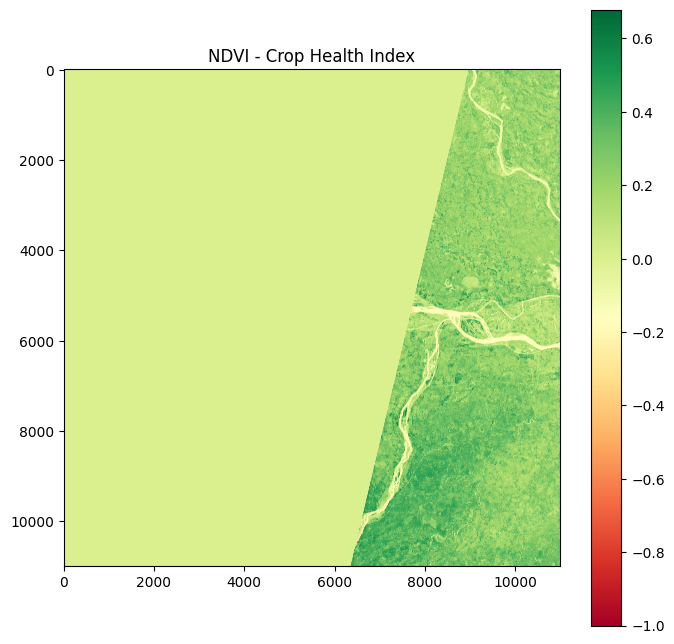

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title("NDVI - Crop Health Index")
plt.show()


In [9]:
ms_image = np.stack([blue, green, red, nir], axis=-1)
print(ms_image.shape)


(10980, 10980, 4)


In [11]:
import cv2

ms_resized = cv2.resize(ms_image, (224,224))
ms_resized = ms_resized / 10000.0   # Sentinel reflectance scaling


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,4)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


d:\Agri 4.0\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
def label_from_ndvi(ndvi):
    if ndvi.mean() > 0.6:
        return 0  # Healthy
    elif ndvi.mean() > 0.4:
        return 1  # Medium
    elif ndvi.mean() > 0.2:
        return 2  # Stressed
    else:
        return 3  # Diseased/low vegetation


In [14]:
patches = []
labels = []

step = 224   # stride

for i in range(0, ms_image.shape[0]-224, step):
    for j in range(0, ms_image.shape[1]-224, step):
        patch = ms_image[i:i+224, j:j+224, :]
        ndvi_patch = ndvi[i:i+224, j:j+224]
        
        label = label_from_ndvi(ndvi_patch)
        
        patches.append(patch)
        labels.append(label)


In [15]:
X = np.array(patches)
y = np.array(labels)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,4)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(4, activation='softmax')  # IMPORTANT FIX
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


d:\Agri 4.0\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
history = model.fit(
    X,
    tf.keras.utils.to_categorical(y, 4),
    batch_size=16,
    epochs=20,
    validation_split=0.2
)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - accuracy: 0.9031 - loss: 512.0849 - val_accuracy: 0.9252 - val_loss: 2.6867
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - accuracy: 0.9516 - loss: 0.6548 - val_accuracy: 0.8836 - val_loss: 3.4452
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 31s 256ms/step - accuracy: 0.9193 - loss: 0.4563 - val_accuracy: 0.9252 - val_loss: 1.4441
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - accuracy: 0.9229 - loss: 0.1702 - val_accuracy: 0.9189 - val_loss: 1.5868
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 31s 257ms/step - accuracy: 0.9182 - loss: 0.2847 - val_accuracy: 0.9397 - val_loss: 0.8181
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 31s 257ms/step - accuracy: 0.9026 - loss: 0.1857 - val_accuracy: 0.9418 - val_loss: 0.9306
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 30s 253ms/step - accuracy: 0.9042 - loss: 0.1470 - val_accuracy: 0.9314 - val_loss: 0.9039
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 30s 251ms/step - accuracy: 0.9172 - loss:

In [22]:
model.save("../backend/models/multispectral_model.h5")
print("Multispectral model saved!")


Multispectral model saved!
